In [1]:
import os
from os import path
import shutil
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
DATASET = os.path.join('workspace', 'dataset')

In [3]:
if not os.path.exists(DATASET):
    !mkdir -p {DATASET}
    # wget is a library to retrieve files through HTTP from the internet.
    !wget -O data.rar https://www.dropbox.com/s/aredlgkmx0d5san/original_images.rar?dl=0 #:~:text=Sign%20up-,Direct,-download
    !mv data.rar {DATASET} 
    %cd {DATASET}
    !unrar x data.rar
    !rm data.rar

Streaming output truncated to the last 5000 lines.
Extracting  original_images/im1024.jpg                                     0%  OK 
Extracting  original_images/im1025.jpg                                     0%  OK 
Extracting  original_images/im1026.jpg                                     0%  OK 
Extracting  original_images/im1027.jpg                                     0%  OK 
Extracting  original_images/im1028.jpg                                     0%  OK 
Extracting  original_images/im1029.jpg                                     0%  OK 
Extracting  original_images/im103.jpg                                      0%  OK 
Extracting  original_images/im1030.jpg                                     0%  OK 
Extracting  original_images/im1031.jpg                                     0%  OK 
Extracting  original_images/im1032.jpg                                     0%  OK 
Extracting  original_images/i

In [4]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [5]:
src_dr='/content/workspace/dataset' ### original dir
directory = 'lr_images'
path = os.path.join(src_dr, directory)
os.mkdir(path)

directory1 = 'hr_images'
path1 = os.path.join(src_dr, directory1)
os.mkdir(path1)

In [6]:
train_dir = src_dr 

for img in os.listdir( train_dir + "/original_images"):
    img_array = cv2.imread(train_dir + "/original_images/" + img)
    
    #img_array = cv2.resize(img_array, (128,128))
    lr_img_array = cv2.GaussianBlur(img_array, (31, 31), 0)
    #lr_img_array = cv2.resize(img_array,(32,32))
    cv2.imwrite(train_dir+ "/hr_images/" + img, img_array)
    cv2.imwrite(train_dir+ "/lr_images/"+ img, lr_img_array)

In [7]:
for img in os.listdir( train_dir + "/original_images"):
    img_array = cv2.imread(train_dir + "/original_images/" + img)
    
    img_array = cv2.resize(img_array, (128,128))
    #lr_img_array = cv2.GaussianBlur(img_array, (31, 31), 0)
    #lr_img_array = cv2.resize(img_array,(32,32))
    cv2.imwrite(train_dir+ "/hr_images/" + img, img_array)

for img in os.listdir(train_dir + "/lr_images"):
    img_array = cv2.imread(train_dir + "/lr_images/" + img)

    lr_img_array = cv2.resize(img_array, (128,128))
    cv2.imwrite(train_dir+ "/lr_images/"+ img, lr_img_array)

In [8]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

In [9]:
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

In [10]:
def upscale_block(ip):
    
    up_model = Conv2D(128, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 1 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

In [11]:
#Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    #layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

In [12]:
#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model

In [13]:
#Descriminartor, as described in the original paper
def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)

In [14]:
#VGG19 
#We need VGG19 for the feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.(as described in the paper)
#Let us pick the 3rd block, last conv layer. 
#Build a pre-trained VGG19 model that outputs image features extracted at the
# third block of the model
# VGG architecture: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py
#from keras.applications import VGG19
from keras.applications.vgg19 import VGG19
def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)


In [15]:
#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

In [16]:
# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 

###################################################################################

#Load first n number of images (to train on a subset of all images)
#For demo purposes, let us use 5000 images
n=5000
lr_list = os.listdir("/content/workspace/dataset/lr_images")[:n]

lr_images = []
for img in lr_list:
    img_lr = cv2.imread("/content/workspace/dataset/lr_images/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr) 

In [17]:
hr_list = os.listdir("/content/workspace/dataset/hr_images")[:n]
   
hr_images = []
for img in hr_list:
    img_hr = cv2.imread("/content/workspace/dataset/hr_images/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)   

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

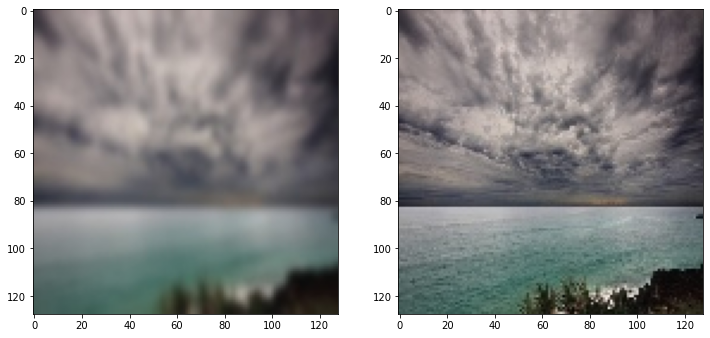

In [18]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (128, 128, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
plt.show()

In [19]:
#Scale values
lr_images = lr_images / 255.
hr_images = hr_images / 255.

#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, 
                                                      test_size=0.33, random_state=42)

In [20]:
hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

In [21]:
generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  15616       ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 p_re_lu (PReLU)                (None, 128, 128, 64  64          ['conv2d[0][0]']                 
                                )                                                             

In [22]:
discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_36 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_37 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_33 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                           

In [23]:
vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

80150528/80134624 [==============================] - 1s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                            

In [24]:
gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

In [25]:
# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 128, 128, 3)  1348867     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                            

In [26]:
#Create a list of images for LR and HR in batches from which a batch of images
#would be fetched during training. 
batch_size = 1  
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

In [27]:
epochs = 50
g_loss_avg = []
epo = []
#Enumerate training over epochs
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    g_loss_avg.append(g_loss)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)

    
    epo.append(e+1)
    
    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)
    

    if (e+1) % 10 == 0: #Change the frequency for model saving, if needed
    #if (e+1) == 2:
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("gen_e_"+ str(e+1) +".h5")


100%|██████████| 3350/3350 [09:31<00:00,  5.87it/s]


epoch: 1 g_loss: 33.85761668667865 d_loss: [1.10994232 0.83044776]


100%|██████████| 3350/3350 [09:11<00:00,  6.07it/s]


epoch: 2 g_loss: 16.99346996819795 d_loss: [0.30805437 0.92447761]


100%|██████████| 3350/3350 [09:10<00:00,  6.08it/s]


epoch: 3 g_loss: 15.609996291416795 d_loss: [0.12504772 0.96298507]


100%|██████████| 3350/3350 [09:09<00:00,  6.09it/s]


epoch: 4 g_loss: 13.838195595990365 d_loss: [0.09540423 0.9738806 ]


100%|██████████| 3350/3350 [09:08<00:00,  6.10it/s]


epoch: 5 g_loss: 13.438030761747218 d_loss: [0.06706608 0.98074627]


100%|██████████| 3350/3350 [09:07<00:00,  6.12it/s]


epoch: 6 g_loss: 12.085413158064458 d_loss: [0.07839144 0.97910448]


100%|██████████| 3350/3350 [09:07<00:00,  6.12it/s]


epoch: 7 g_loss: 12.466960382283624 d_loss: [0.05643402 0.9841791 ]


100%|██████████| 3350/3350 [09:08<00:00,  6.11it/s]


epoch: 8 g_loss: 11.203355901383642 d_loss: [0.05376187 0.98746269]


100%|██████████| 3350/3350 [09:07<00:00,  6.12it/s]


epoch: 9 g_loss: 10.892885649293216 d_loss: [0.04386453 0.9919403 ]


100%|██████████| 3350/3350 [09:15<00:00,  6.03it/s]


epoch: 10 g_loss: 10.455591703795674 d_loss: [0.0329279  0.99492537]


100%|██████████| 3350/3350 [09:18<00:00,  5.99it/s]


epoch: 11 g_loss: 10.250667929649353 d_loss: [0.05607636 0.99089552]


100%|██████████| 3350/3350 [09:14<00:00,  6.04it/s]


epoch: 12 g_loss: 10.080414081011245 d_loss: [0.04638205 0.99432836]


100%|██████████| 3350/3350 [09:12<00:00,  6.06it/s]


epoch: 13 g_loss: 9.72071299622308 d_loss: [0.0560481  0.99402985]


100%|██████████| 3350/3350 [09:11<00:00,  6.07it/s]


epoch: 14 g_loss: 9.577236291490385 d_loss: [0.04053152 0.99462687]


100%|██████████| 3350/3350 [09:11<00:00,  6.08it/s]


epoch: 15 g_loss: 11.311447215738582 d_loss: [0.03998633 0.99507463]


100%|██████████| 3350/3350 [09:10<00:00,  6.09it/s]


epoch: 16 g_loss: 9.309576490441366 d_loss: [0.04538568 0.99283582]


100%|██████████| 3350/3350 [09:12<00:00,  6.06it/s]


epoch: 17 g_loss: 10.13002078426418 d_loss: [0.04047712 0.99477612]


100%|██████████| 3350/3350 [09:17<00:00,  6.01it/s]


epoch: 18 g_loss: 9.090820942707916 d_loss: [0.04610199 0.99358209]


100%|██████████| 3350/3350 [09:12<00:00,  6.07it/s]


epoch: 19 g_loss: 9.087639938272646 d_loss: [0.04837621 0.99477612]


100%|██████████| 3350/3350 [09:01<00:00,  6.19it/s]


epoch: 20 g_loss: 8.650474976852758 d_loss: [0.0255374  0.99776119]


100%|██████████| 3350/3350 [08:57<00:00,  6.23it/s]


epoch: 21 g_loss: 9.122801580357907 d_loss: [0.05765423 0.99597015]


100%|██████████| 3350/3350 [08:56<00:00,  6.24it/s]


epoch: 22 g_loss: 9.330914918895978 d_loss: [0.05046778 0.99641791]


100%|██████████| 3350/3350 [09:01<00:00,  6.19it/s]


epoch: 23 g_loss: 8.304649374627356 d_loss: [0.04118692 0.99567164]


100%|██████████| 3350/3350 [09:04<00:00,  6.15it/s]


epoch: 24 g_loss: 9.519013356237268 d_loss: [0.03199462 0.99746269]


100%|██████████| 3350/3350 [09:03<00:00,  6.16it/s]


epoch: 25 g_loss: 8.461442026825093 d_loss: [0.0417874  0.99776119]


100%|██████████| 3350/3350 [09:02<00:00,  6.18it/s]


epoch: 26 g_loss: 8.124053397143065 d_loss: [8.81883467e-09 1.00000000e+00]


100%|██████████| 3350/3350 [09:01<00:00,  6.19it/s]


epoch: 27 g_loss: 9.551680466683942 d_loss: [9.93437621e-09 1.00000000e+00]


100%|██████████| 3350/3350 [09:00<00:00,  6.20it/s]


epoch: 28 g_loss: 8.248302085559759 d_loss: [3.84301171e-09 1.00000000e+00]


100%|██████████| 3350/3350 [08:58<00:00,  6.23it/s]


epoch: 29 g_loss: 7.868899154485161 d_loss: [7.63686825e-11 1.00000000e+00]


100%|██████████| 3350/3350 [08:56<00:00,  6.25it/s]


epoch: 30 g_loss: 8.179154949810968 d_loss: [2.06856404e-11 1.00000000e+00]


100%|██████████| 3350/3350 [09:06<00:00,  6.13it/s]


epoch: 31 g_loss: 7.574702027591306 d_loss: [9.23990175e-12 1.00000000e+00]


100%|██████████| 3350/3350 [09:03<00:00,  6.17it/s]


epoch: 32 g_loss: 8.518580362049502 d_loss: [0.03370362 0.9980597 ]


100%|██████████| 3350/3350 [09:05<00:00,  6.14it/s]


epoch: 33 g_loss: 10.012490887072548 d_loss: [0.02361802 0.99835821]


100%|██████████| 3350/3350 [09:06<00:00,  6.13it/s]


epoch: 34 g_loss: 7.519441418363087 d_loss: [0.07131284 0.99820896]


100%|██████████| 3350/3350 [09:08<00:00,  6.11it/s]


epoch: 35 g_loss: 8.14868555802018 d_loss: [0.03006001 0.99865672]


100%|██████████| 3350/3350 [09:17<00:00,  6.01it/s]


epoch: 36 g_loss: 7.338561097312329 d_loss: [0.04643144 0.99731343]


100%|██████████| 3350/3350 [09:17<00:00,  6.01it/s]


epoch: 37 g_loss: 7.829778200405747 d_loss: [0.03873085 0.9980597 ]


100%|██████████| 3350/3350 [09:15<00:00,  6.04it/s]


epoch: 38 g_loss: 7.191483391719078 d_loss: [0.0816141  0.99776119]


100%|██████████| 3350/3350 [09:13<00:00,  6.05it/s]


epoch: 39 g_loss: 8.414074179058645 d_loss: [0.03462997 0.99850746]


100%|██████████| 3350/3350 [09:05<00:00,  6.15it/s]


epoch: 40 g_loss: 7.042795298401989 d_loss: [0.04566919 0.99850746]


100%|██████████| 3350/3350 [09:00<00:00,  6.20it/s]


epoch: 41 g_loss: 8.017181488408971 d_loss: [0.06319538 0.99761194]


100%|██████████| 3350/3350 [08:48<00:00,  6.33it/s]


epoch: 42 g_loss: 6.883088224156579 d_loss: [0.07430552 0.99597015]


100%|██████████| 3350/3350 [09:01<00:00,  6.19it/s]


epoch: 43 g_loss: 10.688705256607996 d_loss: [0.05510682 0.99701493]


100%|██████████| 3350/3350 [09:01<00:00,  6.19it/s]


epoch: 44 g_loss: 6.936502539915825 d_loss: [0.05998117 0.99701493]


100%|██████████| 3350/3350 [08:59<00:00,  6.21it/s]


epoch: 45 g_loss: 6.912844843980092 d_loss: [0.02538963 0.99761194]


100%|██████████| 3350/3350 [08:59<00:00,  6.21it/s]


epoch: 46 g_loss: 6.816955175737837 d_loss: [0.06169255 0.99761194]


100%|██████████| 3350/3350 [08:56<00:00,  6.25it/s]


epoch: 47 g_loss: 7.878571583299495 d_loss: [0.0412278  0.99776119]


100%|██████████| 3350/3350 [08:56<00:00,  6.25it/s]


epoch: 48 g_loss: 6.764348326538926 d_loss: [4.84569373e-06 1.00000000e+00]


100%|██████████| 3350/3350 [08:57<00:00,  6.23it/s]


epoch: 49 g_loss: 6.521469076889664 d_loss: [0.04640093 0.99776119]


100%|██████████| 3350/3350 [09:09<00:00,  6.10it/s]


epoch: 50 g_loss: 8.966126491703204 d_loss: [0.05559424 0.99731343]


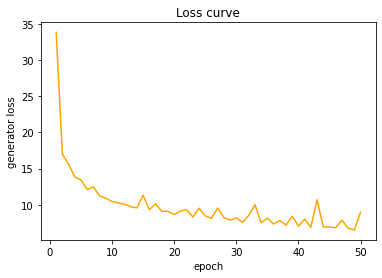

In [28]:
plt.plot(epo, g_loss_avg, color='orange')

#plt.xlim(1,3)
#plt.ylim(1,100)
# naming the x axis
plt.xlabel('epoch')
# naming the y axis
plt.ylabel('generator loss')

plt.title('Loss curve')
  
# function to show the plot
plt.show()

In [29]:
print(e)

49


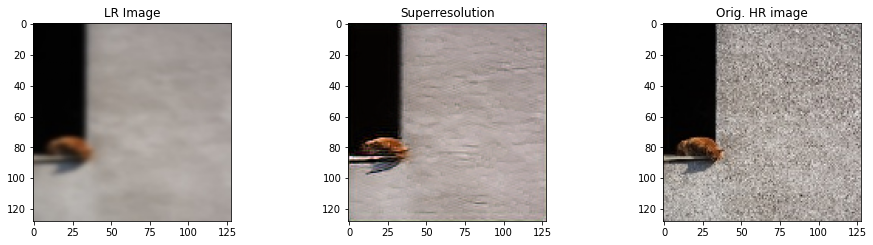

In [30]:
###################################################################################
#Test - perform super resolution using saved generator model
from keras.models import load_model
from numpy.random import randint

generator = load_model('gen_e_50.h5', compile=False)


[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()

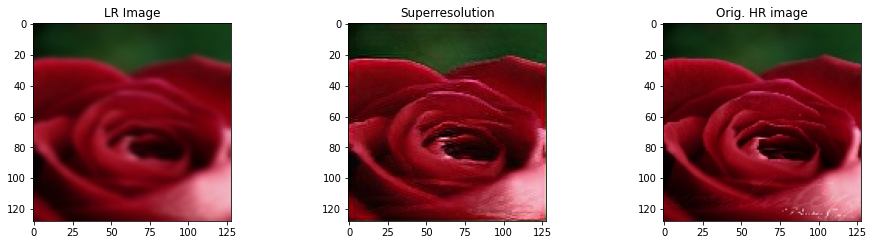

In [31]:

################################################
sreeni_lr = cv2.imread("/content/workspace/dataset/lr_images/im760.jpg")
sreeni_hr = cv2.imread("/content/workspace/dataset/hr_images/im760.jpg")

#Change images from BGR to RGB for plotting. 
#Remember that we used cv2 to load images which loads as BGR.
sreeni_lr = cv2.cvtColor(sreeni_lr, cv2.COLOR_BGR2RGB)
sreeni_hr = cv2.cvtColor(sreeni_hr, cv2.COLOR_BGR2RGB)

sreeni_lr = sreeni_lr / 255.
sreeni_hr = sreeni_hr / 255.

sreeni_lr = np.expand_dims(sreeni_lr, axis=0)
sreeni_hr = np.expand_dims(sreeni_hr, axis=0)

generated_sreeni_hr = generator.predict(sreeni_lr)

# plot all three images
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(sreeni_lr[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(generated_sreeni_hr[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(sreeni_hr[0,:,:,:])

plt.show()

In [32]:
from math import log10, sqrt

In [33]:
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

In [34]:
value = PSNR(sreeni_hr, sreeni_lr)
print(f"PSNR value is {value} dB")

PSNR value is 77.3092484560396 dB


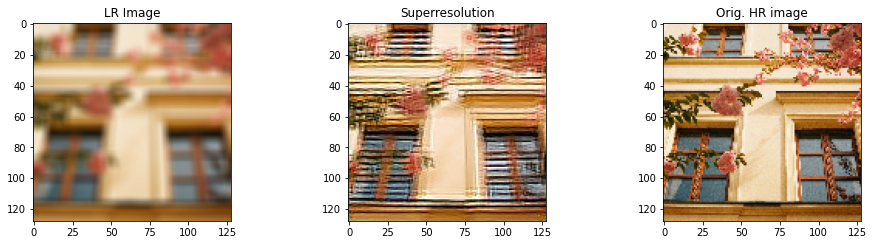

In [35]:
sreeni_lr = cv2.imread("/content/workspace/lr_new_images/1_blur.jpg")
sreeni_hr = cv2.imread("/content/workspace/hr_new_images/1.jpg")



sreeni_lr = cv2.resize(sreeni_lr, (128,128))
sreeni_hr = cv2.resize(sreeni_hr, (128,128))

#Change images from BGR to RGB for plotting. 
#Remember that we used cv2 to load images which loads as BGR.
sreeni_lr = cv2.cvtColor(sreeni_lr, cv2.COLOR_BGR2RGB)
sreeni_hr = cv2.cvtColor(sreeni_hr, cv2.COLOR_BGR2RGB)

sreeni_lr = sreeni_lr / 255.
sreeni_hr = sreeni_hr / 255.

sreeni_lr = np.expand_dims(sreeni_lr, axis=0)
sreeni_hr = np.expand_dims(sreeni_hr, axis=0)

generated_sreeni_hr = generator.predict(sreeni_lr)

# plot all three images
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(sreeni_lr[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(generated_sreeni_hr[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(sreeni_hr[0,:,:,:])

plt.show()

In [36]:
value = PSNR(sreeni_hr, sreeni_lr)
print(f"PSNR value is {value} dB")

PSNR value is 64.52934421539905 dB


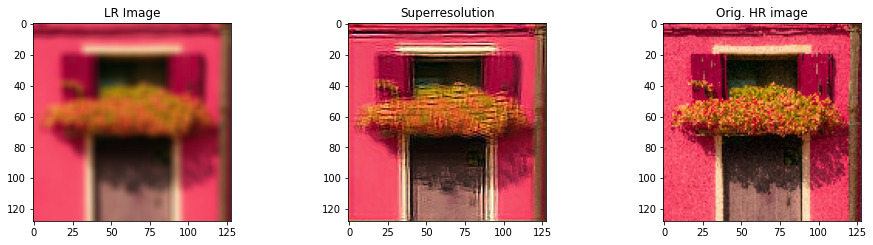

In [37]:
sreeni_lr = cv2.imread("/content/workspace/lr_new_images/2_blur.jpg")
sreeni_hr = cv2.imread("/content/workspace/hr_new_images/2.jpg")
#sreeni_lr = cv2.GaussianBlur(sreeni_hr, (35, 35), 0)

sreeni_lr = cv2.resize(sreeni_lr, (128,128))
sreeni_hr = cv2.resize(sreeni_hr, (128,128))

#Change images from BGR to RGB for plotting. 
#Remember that we used cv2 to load images which loads as BGR.
sreeni_lr = cv2.cvtColor(sreeni_lr, cv2.COLOR_BGR2RGB)
sreeni_hr = cv2.cvtColor(sreeni_hr, cv2.COLOR_BGR2RGB)

sreeni_lr = sreeni_lr / 255.
sreeni_hr = sreeni_hr / 255.

sreeni_lr = np.expand_dims(sreeni_lr, axis=0)
sreeni_hr = np.expand_dims(sreeni_hr, axis=0)

generated_sreeni_hr = generator.predict(sreeni_lr)

# plot all three images
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(sreeni_lr[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(generated_sreeni_hr[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(sreeni_hr[0,:,:,:])

plt.show()

In [38]:
value = PSNR(sreeni_hr, sreeni_lr)
print(f"PSNR value is {value} dB")

PSNR value is 68.4579271326165 dB


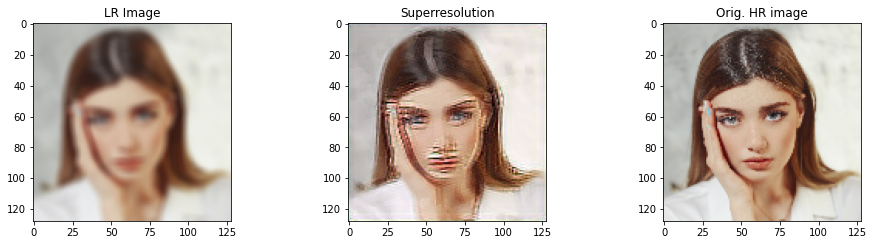

In [39]:
sreeni_lr = cv2.imread("/content/workspace/lr_new_images/3_blur.jpg")
sreeni_hr = cv2.imread("/content/workspace/hr_new_images/3.jpg")

sreeni_lr = cv2.resize(sreeni_lr, (128,128))
sreeni_hr = cv2.resize(sreeni_hr, (128,128))

#Change images from BGR to RGB for plotting. 
#Remember that we used cv2 to load images which loads as BGR.
sreeni_lr = cv2.cvtColor(sreeni_lr, cv2.COLOR_BGR2RGB)
sreeni_hr = cv2.cvtColor(sreeni_hr, cv2.COLOR_BGR2RGB)

sreeni_lr = sreeni_lr / 255.
sreeni_hr = sreeni_hr / 255.

sreeni_lr = np.expand_dims(sreeni_lr, axis=0)
sreeni_hr = np.expand_dims(sreeni_hr, axis=0)

generated_sreeni_hr = generator.predict(sreeni_lr)

# plot all three images
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(sreeni_lr[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(generated_sreeni_hr[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(sreeni_hr[0,:,:,:])

plt.show()

In [40]:
value = PSNR(sreeni_hr, sreeni_lr)
print(f"PSNR value is {value} dB")

PSNR value is 72.08848472862692 dB


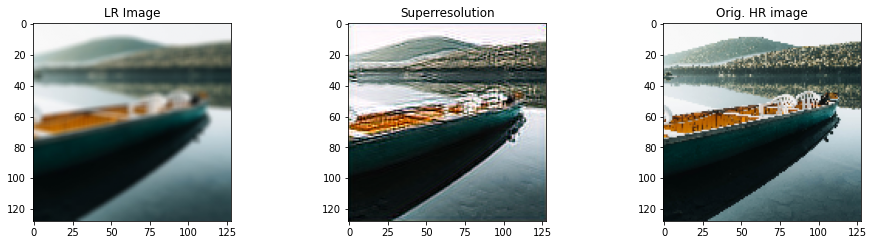

In [41]:
sreeni_lr = cv2.imread("/content/workspace/lr_new_images/4_blur.jpg")
sreeni_hr = cv2.imread("/content/workspace/hr_new_images/4.jpg")

sreeni_lr = cv2.resize(sreeni_lr, (128,128))
sreeni_hr = cv2.resize(sreeni_hr, (128,128))

#Change images from BGR to RGB for plotting. 
#Remember that we used cv2 to load images which loads as BGR.
sreeni_lr = cv2.cvtColor(sreeni_lr, cv2.COLOR_BGR2RGB)
sreeni_hr = cv2.cvtColor(sreeni_hr, cv2.COLOR_BGR2RGB)

sreeni_lr = sreeni_lr / 255.
sreeni_hr = sreeni_hr / 255.

sreeni_lr = np.expand_dims(sreeni_lr, axis=0)
sreeni_hr = np.expand_dims(sreeni_hr, axis=0)

generated_sreeni_hr = generator.predict(sreeni_lr)

# plot all three images
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(sreeni_lr[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(generated_sreeni_hr[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(sreeni_hr[0,:,:,:])

plt.show()

In [42]:
value = PSNR(sreeni_hr, sreeni_lr)
print(f"PSNR value is {value} dB")

PSNR value is 69.04752595958755 dB
